Cost: 
  [CH-Dav] Dist=19.53 km | Height Diff=58.19 mIdx=(np.int64(157), np.int64(78)) | Slope=0.1° | Slope diff=0.1° | Aspect=192.9° | Aspect diff=5.2° | VegFrac=0.94 | Cost=0.020
Cost: 
  [IT-Lav] Dist=22.20 km | Height Diff=3.15 mIdx=(np.int64(53), np.int64(185)) | Slope=0.0° | Slope diff=0.0° | Aspect=248.9° | Aspect diff=18.3° | VegFrac=1.00 | Cost=0.011
Cost: 
  [IT-Ren] Dist=13.11 km | Height Diff=0.79 mIdx=(np.int64(144), np.int64(169)) | Slope=0.1° | Slope diff=0.0° | Aspect=143.4° | Aspect diff=15.2° | VegFrac=0.95 | Cost=0.010
Cost: 
  [AT-Neu] Dist=29.49 km | Height Diff=23.97 mIdx=(np.int64(171), np.int64(184)) | Slope=0.2° | Slope diff=0.2° | Aspect=27.8° | Aspect diff=11.2° | VegFrac=0.83 | Cost=0.029
Cost: 
  [IT-MBo] Dist=0.37 km | Height Diff=89.37 mIdx=(np.int64(75), np.int64(151)) | Slope=0.1° | Slope diff=0.0° | Aspect=337.0° | Aspect diff=0.0° | VegFrac=0.91 | Cost=0.027
     site      country  pft pft_id      lat      lon  hgt_site  model_pft  \
0  CH-Dav  Switze

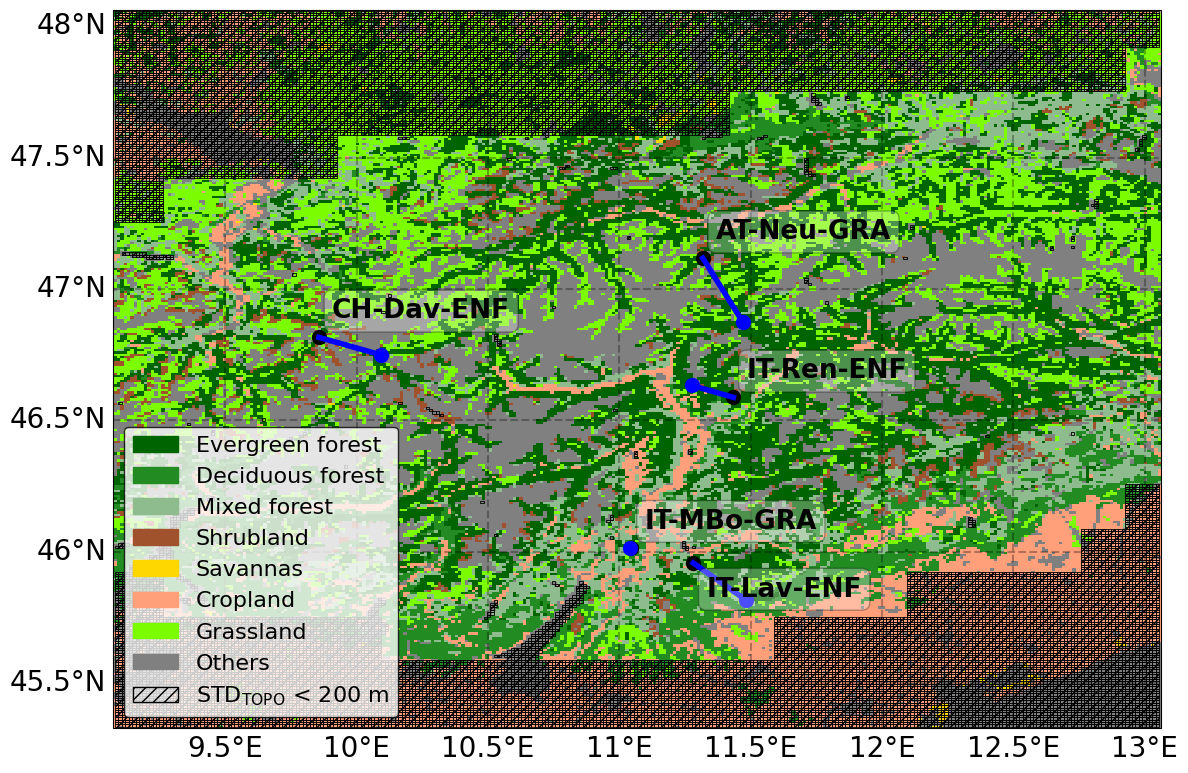

In [12]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pyVPRM.lib.fancy_plot import *
from rioxarray import merge
import numpy as np
import os
import glob
import xarray as xr
import shutil
import cartopy.crs as ccrs
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import netCDF4 as nc
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from matplotlib.patches import Patch

def compute_slope_aspect(hgt, lats, lons):
    lat_rad = np.radians(lats)
    dy = 111000  # meters per degree latitude
    dx = 111000 * np.cos(lat_rad)  # meters per degree longitude

    dz_dy = np.gradient(hgt, axis=0) / dy
    dz_dx = np.gradient(hgt, axis=1) / dx

    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope = np.degrees(slope_rad)

    aspect = (np.degrees(np.arctan2(dz_dy, -dz_dx)) + 360) % 360
    return slope, aspect


def haversine_dist(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def find_best_fluxnet_match(
    lat_target,
    lon_target,
    lats,
    lons,
    location_pft,
    veg_frac_map,
    hgt,
    hgt_site,
    radius,
    slope=None,
    aspect=None,
):
    if slope is None or aspect is None:
        slope, aspect = compute_slope_aspect(hgt, lats, lons)

    # Site reference
    flat_idx = np.abs(lats - lat_target) + np.abs(lons - lon_target)
    lat_idx, lon_idx = np.unravel_index(np.argmin(flat_idx), lats.shape)
    target_slope = slope[lat_idx, lon_idx]
    target_aspect = aspect[lat_idx, lon_idx]

    # Distance constraint
    dist_km = haversine_dist(lat_target, lon_target, lats, lons)
    dist_mask = dist_km <= abs(radius)

    # Terrain differences
    height_diff = np.abs(hgt - hgt_site)
    slope_diff = np.abs(slope - target_slope)
    aspect_diff = np.abs((aspect - target_aspect + 180) % 360 - 180)

    # Vegetation fraction (axis 1 = PFT)
    veg_frac = veg_frac_map[0, location_pft - 1, :, :]  # shape (ny, nx)

    # Define weighted cost function
    cost = (
        0.5 * (height_diff / np.nanmax(height_diff))
        + 0.1 * (slope_diff / 90.0)
        + 0.1 * (aspect_diff / 180.0)
        + 0.6 * (1.0 - veg_frac) ** 2
    )

    # Apply radius mask
    cost = np.where(dist_mask, cost, np.inf)

    if not np.any(np.isfinite(cost)):
        raise ValueError("No valid grid cell within radius.")

    min_idx = np.unravel_index(np.argmin(cost), cost.shape)
    min_dist = dist_km[min_idx]

    return (
        min_dist,
        min_idx,
        target_slope,
        slope_diff[min_idx],
        target_aspect,
        aspect_diff[min_idx],
        veg_frac[min_idx],
        height_diff[min_idx],
        cost[min_idx],
    )

def find_nearest_grid_hgt_sa(
    lat_target, lon_target, lats, lons, location_pft, IVGTYP_vprm, hgt, hgt_site, radius
):
    slope, aspect = compute_slope_aspect(hgt, lats, lons)

    flat_idx = np.abs(lats - lat_target) + np.abs(lons - lon_target)
    min_flat_idx = np.argmin(flat_idx)
    lat_idx, lon_idx = np.unravel_index(min_flat_idx, lats.shape)
    target_slope = slope[lat_idx, lon_idx]
    target_aspect = aspect[lat_idx, lon_idx]

    pft_mask = IVGTYP_vprm == location_pft
    dist_km = haversine_dist(lat_target, lon_target, lats, lons)
    dist_mask = dist_km <= abs(radius)

    height_diff = np.abs(hgt - hgt_site)
    slope_diff = np.abs(slope - target_slope)
    aspect_diff = np.abs((aspect - target_aspect + 180) % 360 - 180)

    aspect_mask = aspect_diff <= 20
    slope_mask = slope_diff <= 10

    combined_mask = pft_mask & dist_mask & aspect_mask & slope_mask

    if not np.any(combined_mask):
        relaxed_mask = pft_mask & dist_mask
        if np.any(relaxed_mask):
            masked_height_diff = np.where(relaxed_mask, height_diff, np.inf)
            min_idx = np.unravel_index(np.argmin(masked_height_diff), hgt.shape)
            min_dist = dist_km[min_idx]
            return min_dist, min_idx, target_slope,target_aspect
        else:
            fallback_flat_idx = np.argmin(dist_km)
            fallback_idx = np.unravel_index(fallback_flat_idx, lats.shape)
            fallback_dist = dist_km[fallback_idx]
            return fallback_dist, fallback_idx, target_slope,target_aspect 

    masked_height_diff = np.where(combined_mask, height_diff, np.inf)
    min_idx = np.unravel_index(np.argmin(masked_height_diff), hgt.shape)
    min_dist = dist_km[min_idx]

    return min_dist, min_idx, target_slope,target_aspect


def find_nearest_grid_hgt(
    lat_target, lon_target, lats, lons, location_pft, IVGTYP_vprm, hgt, hgt_site, radius
):
    """Find the nearest grid index for a given lat/lon with the same PFT and lowest height difference."""

    # Get valid lat/lon values
    valid_mask = IVGTYP_vprm == location_pft
    valid_lats = np.where(valid_mask, lats, np.nan)
    valid_lons = np.where(valid_mask, lons, np.nan)

    # Convert latitude and longitude differences to km
    lat_diff = (
        valid_lats - lat_target
    )  # * 111  # approximate conversion factor for degrees to km
    lon_diff = (
        valid_lons - lon_target  # * 111 * np.cos(np.radians(lat_target))
    )  # adjust for latitude
    dist = np.sqrt(lat_diff**2 + lon_diff**2)
    dist_km = dist * 111  # approximate conversion factor for degrees to km

    # Mask the distance to only consider points within the radius
    within_radius_mask = dist_km <= abs(radius)
    dist_within_radius = np.where(within_radius_mask, dist_km, np.nan)

    # Check if there are valid points within the radius
    if np.all(np.isnan(dist_within_radius)):
        min_index = np.unravel_index(np.nanargmin(dist), lats.shape)
        return np.nanmin(dist_km),min_index  # No valid points found within the radius, closest index is given back without checking height

    # Calculate the height difference for points within the radius
    height_diff_within_radius = np.where(
        within_radius_mask, np.abs(hgt - hgt_site), np.nan
    )

    # Get the index of the minimum height difference within the radius
    min_height_diff_idx = np.unravel_index(
        np.nanargmin(height_diff_within_radius), lats.shape
    )

    # Get the value of the distance with the minimum height
    dist_idx = dist_within_radius[min_height_diff_idx[0], min_height_diff_idx[1]]

    # Return the minimum distance and the index of the minimum height difference
    return dist_idx, min_height_diff_idx

def get_int_var(lat_target, lon_target, lats, lons, WRF_var):
    interpolator = RegularGridInterpolator((lats[:, 0], lons[0, :]), WRF_var)
    interpolated_value = interpolator((lat_target, lon_target))
    return interpolated_value
############# INPUT ############
domain = "_d02"
dx = "_1km" 
dx_int = dx[1:-2] 
radius = 30 # should be set to dx*20 to fit to extract_timeseries.py
std_threshold = 200
base_mz =  '/scratch/c7071034/DATA/pyVPRM/pyVPRM_examples/wrf_preprocessor/out'+domain+'_2012'+dx

if dx == "_1km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_3km/wrfinput_d02"
elif dx == "_3km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_3km/wrfinput_d01"
elif dx == "_9km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_9km/wrfinput_d01"
elif dx == "_27km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_27km/wrfinput_d01"
elif dx == "_54km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_54km/wrfinput_d01"

t_file_fra = 'VPRM_input_VEG_FRA'+domain+'_2012.nc'
# t_file_fra = 'VPRM_input_VEG_FRA_2022.nc'
locations_hgt = {
        "AT-Neu": 970,
        "CH-Cha": 393,
        "CH-Dav": 1639,
        "CH-Fru": 982,
        "CH-Lae": 689,
        "CH-Oe1": 450,
        "CH-Oe2": 452,
        "DE-Lkb": 1308,
        "IT-Isp": 210,
        "IT-La2": 1350,
        "IT-Lav": 1353,
        "IT-MBo": 1550,
        "IT-PT1": 60,
        "IT-Ren": 1730,
        "IT-Tor": 2160,
    }

if dx == "_1km" :
    sites = [
    {"site": "CH-Dav", "country": "Switzerland", "pft": "ENF", "pft_id": "1", "lat": 46.8153, "lon": 9.8559,"hgt_site": 1639},
    {"site": "IT-Lav", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 45.9562, "lon": 11.2813,"hgt_site": 1353},
    {"site": "IT-Ren", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 46.5869, "lon": 11.4337,"hgt_site": 1730},
    {"site": "AT-Neu", "country": "Austria", "pft": "GRA", "pft_id": "7", "lat": 47.1167, "lon": 11.3175,"hgt_site": 970},
    {"site": "IT-MBo", "country": "Italy", "pft": "GRA", "pft_id": "7", "lat": 46.0147, "lon": 11.0458,"hgt_site": 1550},
]
else:
    sites = [
        {"site": "IT-Isp", "country": "Italy", "pft": "DBF", "pft_id": "2", "lat": 45.8126, "lon": 8.6336,"hgt_site":210},
        {"site": "CH-Oe2", "country": "Switzerland", "pft": "CRO", "pft_id": "6", "lat": 47.2863, "lon": 7.7343,"hgt_site": 452},
        {"site": "IT-PT1", "country": "Italy", "pft": "DBF", "pft_id": "2", "lat": 45.2009, "lon": 9.061,"hgt_site":60},
        {"site": "CH-Dav", "country": "Switzerland", "pft": "ENF", "pft_id": "1", "lat": 46.8153, "lon": 9.8559,"hgt_site": 1639},
        {"site": "DE-Lkb", "country": "Germany", "pft": "ENF", "pft_id": "1", "lat": 49.0996, "lon": 13.3047,"hgt_site": 1308},
        {"site": "IT-La2", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 45.9542, "lon": 11.2853,"hgt_site":1350},
        {"site": "IT-Lav", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 45.9562, "lon": 11.2813,"hgt_site": 1353},
        {"site": "IT-Ren", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 46.5869, "lon": 11.4337,"hgt_site": 1730},
        {"site": "AT-Neu", "country": "Austria", "pft": "GRA", "pft_id": "7", "lat": 47.1167, "lon": 11.3175,"hgt_site": 970},
        {"site": "CH-Cha", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.2102, "lon": 8.4104,"hgt_site":393},
        {"site": "CH-Fru", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.1158, "lon": 8.5378,"hgt_site":982},
        {"site": "CH-Oe1", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.2858, "lon": 7.7319,"hgt_site":450},
        {"site": "IT-MBo", "country": "Italy", "pft": "GRA", "pft_id": "7", "lat": 46.0147, "lon": 11.0458,"hgt_site": 1550},
        {"site": "IT-Tor", "country": "Italy", "pft": "GRA", "pft_id": "7", "lat": 45.8444, "lon": 7.5781,"hgt_site": 2160},
        {"site": "CH-Lae", "country": "Switzerland", "pft": "MF", "pft_id": "3", "lat": 47.4781, "lon": 8.3644,"hgt_site": 689},
    ]

# CORINE vegetation type labels
vegetation_labels = [
    "Continuous Urban Fabric", "Discontinuous Urban Fabric", "Industrial or Commercial Units",
    "Road and Rail Networks", "Port Areas", "Airports", "Mineral Extraction Sites", 
    "Dump Sites", "Construction Sites", "Green Urban Areas", "Sport and Leisure Facilities", 
    "Non-irrigated Arable Land", "Permanently Irrigated Land", "Rice Fields", "Vineyards", 
    "Fruit Trees and Berry Plantations", "Olive Groves", "Pastures", "Annual Crops Associated with Permanent Crops",
    "Complex Cultivation Patterns", "Land Principally Occupied by Agriculture", "Agro-forestry Areas", 
    "Broad-leaved Forest", "Coniferous Forest", "Mixed Forest", "Natural Grasslands", "Moors and Heathland", 
    "Sclerophyllous Vegetation", "Transitional Woodland-Shrub", "Beaches, Dunes, Sands", "Bare Rocks",
    "Sparsely Vegetated Areas", "Burnt Areas", "Glaciers and Perpetual Snow", "Inland Marshes", 
    "Peat Bogs", "Salt Marshes", "Salines", "Intertidal Flats", "Water Courses", "Water Bodies",
    "Coastal Lagoons", "Estuaries"
]

# Define a color map for CORINE vegetation types
vegetation_colors = [
    "#FF0000", "#FF4500", "#B22222", "#808080", "#4682B4", "#87CEFA", "#8B4513", 
    "#A0522D", "#D2691E", "#32CD32", "#7FFF00", "#FFFF00", "#FFD700", "#F0E68C", "#8B0000", 
    "#B8860B", "#CD853F", "#ADFF2F", "#DDA0DD", "#F5DEB3", "#FFE4C4", "#DEB887", "#228B22", 
    "#006400", "#8FBC8F", "#7CFC00", "#556B2F", "#6B8E23", "#8B7500", "#F4A460", "#A9A9A9", 
    "#D3D3D3", "#FFFFFF", "#2E8B57", "#3CB371", "#20B2AA", "#5F9EA0", "#48D1CC", "#00CED1", 
    "#1E90FF", "#0000CD", "#4682B4", "#708090"
]

corine_to_vprm = {
    24: 1,            # Coniferous Forest (Evergreen)
    23: 2,            # Broad-leaved Forest (Deciduous)
    25: 3, 29: 3,     # Mixed Forest and Transitional Woodland-Shrub
    27: 4, 28: 4,     # Moors and Heathland, Sclerophyllous Vegetation (Shrubland)
    35: 5, 36: 5, 37: 5,  # Wetlands: Inland Marshes, Peat Bogs, Salt Marshes
    12: 6, 13: 6, 14: 6, 15: 6, 16: 6, 17: 6, 19: 6, 20: 6, 21: 6, 22: 6,  # Cropland
    18: 7, 26: 7,     # Grassland: Pastures, Natural Grasslands
    # Others mapped to 8 (gray)
    1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 8, 9: 8, 10: 8, 11: 8, 
    30: 8, 31: 8, 32: 8, 33: 8, 34: 8, 38: 8, 39: 8, 40: 8, 41: 8, 42: 8, 43: 8, 44: 8
}

# Define labels for the simplified vegetation types
labels_vprm_short = [
    "ENF", "DBF", "MF", "SHB", 
    "SAV", "CRO", "GRA", "OTH"  # Include "Others"
]
# Load the NetCDF file
nc_fid = nc.Dataset(wrfinput_path, "r")
IVGTYP = nc_fid.variables['IVGTYP'][0, 10:-10, 10:-10]
IVGTYP.shape
# Retrieve the CORINE vegetation types (IVGTYP) and coordinates (XLAT, XLONG)
XLAT = nc_fid.variables['XLAT'][0, 10:-10, 10:-10]  # Assuming the first time slice
XLONG = nc_fid.variables['XLONG'][0, 10:-10, 10:-10]
HGT_M = nc_fid.variables['HGT'][0, 10:-10, 10:-10]
STDVAR = nc_fid.variables['VAR'][0, 10:-10, 10:-10]
IVGTYP_vprm = np.vectorize(corine_to_vprm.get)(
            IVGTYP[ :,:])
IVGTYP_vprm.shape

in_veg_frac = xr.open_dataset(os.path.join(base_mz, t_file_fra))
veg_frac_map = in_veg_frac['vegetation_fraction_map'][:, 10:-10, 10:-10]

veg_frac_class_8 = veg_frac_map.sel(vprm_classes=8)
mask_ivgtyp_trimmed = IVGTYP == 44
veg_frac_class_8 = veg_frac_class_8.where(~mask_ivgtyp_trimmed, 1)

veg_frac_map.loc[{'vprm_classes': 8}] = veg_frac_class_8

# Proceed from trimmed veg_frac_map only
VPRM_in_dom_vgtyp = veg_frac_map.argmax(dim='vprm_classes') + 1
df_VPRM_in_dom_vgtyp = VPRM_in_dom_vgtyp.to_dataframe(name='vegetation_type').reset_index()
if dx == "_1km":
    d0X = "wrfout_d02"
    vprm_input_path_1km = f"/scratch/c7071034/DATA/VPRM_input/vprm_corine_1km/vprm_input_d02_2012-06-23_00:00:00.nc"
    ds = xr.open_dataset(vprm_input_path_1km)
    # ['Times', 'XLONG', 'XLAT', 'EVI_MIN', 'EVI_MAX', 'EVI', 'LSWI_MIN', 'LSWI_MAX', 'LSWI', 'VEGFRA_VPRM']
    veg_frac_map = ds["VEGFRA_VPRM"].isel(south_north=slice(10, -10), west_east=slice(10, -10)).values
    veg_frac_map = np.nan_to_num(veg_frac_map, nan=0.0)
else:
    vprm_input_path = f"/scratch/c7071034/DATA/VPRM_input/vprm_corine_{res}/vprm_input_d01_2012-06-23_00:00:00.nc"
    ds = xr.open_dataset(vprm_input_path)
    # ['Times', 'XLONG', 'XLAT', 'EVI_MIN', 'EVI_MAX', 'EVI', 'LSWI_MIN', 'LSWI_MAX', 'LSWI', 'VEGFRA_VPRM']
    veg_frac_map = ds["VEGFRA_VPRM"].values
    veg_frac_map = np.nan_to_num(veg_frac_map, nan=0.0)




# find pft match in 10 dx radius with same height
# Append model PFT to each site
for site in sites:
    lat, lon = site["lat"], site["lon"]
    #dist_km, grid_idx, target_slope,target_aspect = find_nearest_grid_hgt_sa(lat, lon, XLAT, XLONG,int(site["pft_id"]),VPRM_in_dom_vgtyp,HGT_M,site["hgt_site"],radius)

    (
        dist_km,
        grid_idx,
        target_slope,
        target_slope_diff,
        target_aspect,
        target_aspect_diff,
        veg_frac_idx,
        height_diff_idx,
        cost,
    ) = find_best_fluxnet_match(lat, lon, XLAT, XLONG, int(site["pft_id"]), veg_frac_map, HGT_M, site["hgt_site"], radius)
    print(
                f"Cost: \n  [{site['site']}] "
                f"Dist={dist_km:.2f} km | "
                f"Height Diff={height_diff_idx:.2f} m"
                f"Idx={grid_idx} | "
                f"Slope={target_slope:.1f}° | "
                f"Slope diff={target_slope_diff:.1f}° | "
                f"Aspect={target_aspect:.1f}° | "
                f"Aspect diff={target_aspect_diff:.1f}° | "
                f"VegFrac={veg_frac_idx:.2f} | "
                f"Cost={cost:.3f}"
            )

    site["model_pft"] = IVGTYP[grid_idx[0],grid_idx[1]]
    site["model_hgt_NN"] = HGT_M[grid_idx[0],grid_idx[1]]
    site["model_lat"] = XLAT[grid_idx[0],grid_idx[1]]
    site["model_lon"] = XLONG[grid_idx[0],grid_idx[1]]
    site["dist_km"] = dist_km
    site["target_slope"] = target_slope
    site["target_aspect"] = target_aspect
    site["model_pft_CLC"] = vegetation_labels[site["model_pft"]-1]
    site["model_pft_CLC_to_VPRM"] = labels_vprm_short[corine_to_vprm[site["model_pft"]]-1]
    #site["model_pft_VPRM_dom_id"] = int(VPRM_in_dom_vgtyp[grid_idx[0],grid_idx[1]])
    if site["pft"] == site["model_pft_CLC_to_VPRM"]:
        site["pft_match"] = True
    else:
        site["pft_match"] = False

# Convert to DataFrame for tabular output
df_sites_match = pd.DataFrame(sites)

# Print the table
print(df_sites_match)
df_sites_match.to_csv("pft_site_match_at"+dx+".csv" )



# Define the colors for the vegetation types (7 colors + gray for 8 others)
custom_colors = ["#006400", "#228B22", "#8FBC8F", "#A0522D", 
                 "#FFD700", "#FFA07A", "#7CFC00", "#808080"]  # Added gray for "Others"

# Create a colormap using the defined colors
cmap_simplified = mcolors.ListedColormap(custom_colors)

# Define the remapping dictionary for CORINE vegetation types
corine_to_vprm = {
    24: 1,            # Coniferous Forest (Evergreen)
    23: 2,            # Broad-leaved Forest (Deciduous)
    25: 3, 29: 3,     # Mixed Forest and Transitional Woodland-Shrub
    27: 4, 28: 4,     # Moors and Heathland, Sclerophyllous Vegetation (Shrubland)
    35: 5, 36: 5, 37: 5,  # Wetlands: Inland Marshes, Peat Bogs, Salt Marshes
    12: 6, 13: 6, 14: 6, 15: 6, 16: 6, 17: 6, 19: 6, 20: 6, 21: 6, 22: 6,  # Cropland
    18: 7, 26: 7,     # Grassland: Pastures, Natural Grasslands
    # Others mapped to 8 (gray)
    1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 8, 9: 8, 10: 8, 11: 8, 
    30: 8, 31: 8, 32: 8, 33: 8, 34: 8, 38: 8, 39: 8, 40: 8, 41: 8, 42: 8, 43: 8, 44: 8
}

# Define vegetation type labels
veg_labels = [
    "Evergreen forest", "Deciduous forest", "Mixed forest", "Shrubland", 
    "Savannas", "Cropland", "Grassland", "Others"
]

# Define a color map with 8 distinct colors for the vegetation types
colors = ["#006400", "#228B22", "#8FBC8F", "#A0522D", 
          "#FFD700", "#FFA07A", "#7CFC00", "#808080"]  # Including gray for "Others"
cmap = mcolors.ListedColormap(colors)

# Boundaries for each vegetation type (1 to 8, with an extra to close the last bin)
bounds = list(range(1, 10))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Pivot the DataFrame to create 2D arrays for plotting
veg_2d = df_VPRM_in_dom_vgtyp.pivot(index='lat', columns='lon', values='vegetation_type')
#veg_2d.fillna(0, inplace=True)

# mask low std areas (kept separate from veg values)
mask_low_std = STDVAR < std_threshold

# Create the plot
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# main vegetation plot (draw first, so grey can go ON TOP)
veg_plot = ax.pcolormesh(
    veg_2d.columns.values,
    veg_2d.index.values,
    veg_2d.values,
    cmap=cmap, norm=norm,
    transform=ccrs.PlateCarree(),
    zorder=0
)

# --- HATCHED overlay on top using PolyCollection (correct coverage + border) ---
from matplotlib.collections import PolyCollection

low_polys = []

lat_vals = veg_2d.index.values
lon_vals = veg_2d.columns.values

for i in range(len(lat_vals) - 1):
    for j in range(len(lon_vals) - 1):
        if mask_low_std[i, j]:
            # build the cell polygon
            poly = [
                (lon_vals[j],     lat_vals[i]),
                (lon_vals[j+1],   lat_vals[i]),
                (lon_vals[j+1],   lat_vals[i+1]),
                (lon_vals[j],     lat_vals[i+1])
            ]
            low_polys.append(poly)

# build hatched collection
coll = PolyCollection(
    low_polys,
    facecolor='none',
    edgecolor='black',   # border around every hatched cell
    hatch='///',
    linewidth=0.6,       # visible cell boundaries
    zorder=20,
    transform=ccrs.PlateCarree()
)

ax.add_collection(coll)

# --- Legend including hatch pattern ---
patches = [Patch(color=colors[k], label=lab) for k, lab in enumerate(veg_labels)]

# add hatched legend entry
hatched_patch = Patch(facecolor='none', edgecolor='black', hatch='///', label=r"STD$_\text{TOPO}$ < 200 m")
patches.append(hatched_patch)

leg = ax.legend(handles=patches, loc="lower left", fontsize=16)
leg.set_zorder(1000)            # force legend to front
leg.get_frame().set_facecolor('white')   # optional: ensure readability
leg.get_frame().set_edgecolor('black')   # optional border

gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Plot markers for each FLUXNET site
for index, site in df_sites_match.iterrows():
    label = f"{site['site']}-{site['pft']}"  # Create label as 'site-pft'

    # Adjust specific label positions if necessary
    if site["site"] == "IT-Lav":
        text_offset_x, text_offset_y = 0.05, -0.1
    else:
        text_offset_x, text_offset_y = 0.05, 0.1

    if site["pft_match"]:
        colorx = 'blue'
    else:
        colorx = 'purple'

    # Plot the marker
    ax.plot(
        site["lon"], site["lat"],
        marker='o',
        color = 'black',
        markersize=10,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )
    ax.plot(
        site["model_lon"], site["model_lat"],
        marker='o',
        color = 'blue',
        markersize=10,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )
    # add blue dashed lines to connect the site and model point
    ax.plot(
        [site["lon"], site["model_lon"]], 
        [site["lat"], site["model_lat"]],
        color='blue',
        linestyle='-',
        linewidth=4,
        transform=ccrs.PlateCarree()
    )

    # Add the label
    ax.text(
        site["lon"] + text_offset_x, site["lat"] + text_offset_y,
        label,
        color='black',
        transform=ccrs.PlateCarree(),
        fontsize=19,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.3,  boxstyle='round, pad=0.3'),
        ha='left',
        va='center'
    )
    
plt.xticks(fontsize=18)     # for tick labels
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig(f"VGT_VPRM_{domain+dx}.eps", format='eps', bbox_inches='tight', dpi=100)
plt.savefig(f"plots/VGT_VPRM_{domain+dx}_STD{std_threshold}.pdf", bbox_inches='tight')
plt.show()


In [2]:
# Evergreen Forest:
#     vprm_class: 1
#     class_numbers:
#         - 24  # Coniferous Forest

# Deciduous Forest:
#     vprm_class: 2
#     class_numbers:
#         - 23  # Broad-leaved Forest

# Mixed Forest:
#     vprm_class: 3
#     class_numbers:
#         - 25  # Mixed Forest
#         - 29  # Transitional Woodland-Shrub

# Shrubland:
#     vprm_class: 4
#     class_numbers:
#         - 27  # Moors and Heathland
#         - 28  # Sclerophyllous Vegetation

# Wetlands:
#     vprm_class: 5
#     class_numbers:
#         - 35  # Inland Marshes
#         - 36  # Peat Bogs
#         - 37  # Salt marshes

# Cropland:
#     vprm_class: 6
#     class_numbers:
#         - 12  # Non-irrigated Arable Land
#         - 13  # Permanently Irrigated Land
#         - 15  # Vineyards
#         - 16  # Fruit Trees and Berry Plantations
#         - 17  # Olive Groves
#         - 19  # Annual Crops Associated with Permanent Crops
#         - 20  # Complex Cultivation Patterns
#         - 21  # Land Principally Occupied by Agriculture
#         - 22  # Agro-forestry areas
#         - 14  # Rice Fields

# Grassland:
#     vprm_class: 7
#     class_numbers:
#       - 18  # Pastures
#       - 26  # Natural Grasslands

# Other:
#     vprm_class: 8
#     class_numbers:
#       - 1   # Continuous Urban Fabric
#       - 2   # Discontinuous Urban Fabric
#       - 3   # Industrial or Commercial Units
#       - 4   # Road and Rail Networks
#       - 5   # Port Areas
#       - 6   # Airports
#       - 7   # Mineral Extraction Sites
#       - 8   # Dump Sites
#       - 9   # Construction Sites
#       - 10  # Green Urban Areas
#       - 11  # Sport and Leisure Facilities
#       - 30  # Beaches, Dunes, Sands
#       - 31  # Bare Rocks
#       - 32  # Sparsely Vegetated Areas
#       - 33  # Burnt Areas
#       - 34  # Glaciers and Perpetual Snow
#       - 38  # Salines
#       - 39  # Intertidal flats
#       - 40  # Water courses
#       - 41  # Water bodies
#       - 42  # Coastal lagoons
#       - 43  # Estuaries
#       - 44  # Estuaries